<a href="https://colab.research.google.com/github/Manal-art-coder/Analyse-des-avis-clients-sur-un-site-de-e-commerce/blob/main/Analyse_des_avis_clients_sur_un_site_de_e_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyse des avis clients sur un site de e-commerce

**Objectif du projet** : Notre objectif pour ce projet est de réussir à prédire la note d’un client pour une commande sur un site de e-commerce. En effet, la réassurance des clients est un facteur clé dans leur parcours d’achat : les avis clients permettent de mettre en confiance l’acheteur et le pousser à concrétiser son achat. Ainsi, nous allons à travers cette modélisation déduire les facteurs sur lesquels nous pouvons composer pour améliorer les notes des produits disponibles à la vente sur notre site marchand. Ceci permettra d’attirer plus de clients et d’optimiser les ventes.

Pour mener à bien cette étude, nous allons :

-Extraire les données et bien les comprendre

-Réaliser des dataviz explicites

-Enrichir notre jeu de données avec de nouvelles variables

-Modéliser le problème

-Tester notre modèle

Nous disposons de données relatives aux ventes de produits sur un site de e-commerce brésilien.



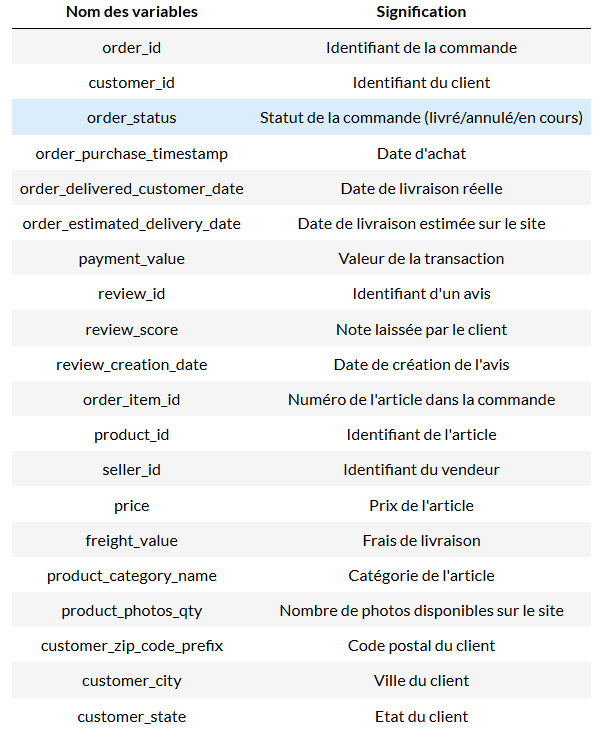


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, precision_score, recall_score
import sqlite3

Les données sont fractionnées en bases de données relationnelles, ci-dessous quelques requêtes en SQL qui nous ont permis de fusionner les bases de données.

In [21]:
import pandas as pd
import sqlite3

sql_query = '''
select order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,
order_estimated_delivery_date,payment_value,review_id,review_score,review_creation_date,order_item_id,
product_id,seller_id,price,freight_value,product_category_name,product_photos_qty,customer_zip_code_prefix,
customer_city,customer_state from
(
select *
from
(
select *
from orders o join order_payments p on o.order_id = p.order_id
                            join order_items i on o.order_id = i.order_id
                            join order_reviews r on o.order_id = r.order_id

)
as t1 join customers t2 on t1.customer_id = t2.customer_id
      join products t3 on t1.product_id = t3.product_id
	  join sellers t4 on t1.seller_id = t4.seller_id
)

'''

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Spécifier le chemin local du fichier SQLite (remplacez par votre chemin correct)
db_path = "/content/drive/MyDrive/olist.sqlite"

# Connexion à SQLite
db_connection = sqlite3.connect(db_path)

# Exécuter la requête SQL
df = pd.read_sql(sql_query, db_connection)

# Fermer la connexion
db_connection.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### I) Exploration des données

In [22]:
# Afficher les premières lignes du dataframe
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_id,review_score,review_creation_date,order_item_id,product_id,seller_id,price,freight_value,product_category_name,product_photos_qty,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,4.0,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,4.0,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,8.72,utilidades_domesticas,4.0,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,141.46,8d5266042046a06655c8db133d120ba5,4,2018-08-08 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,118.70,22.76,perfumaria,1.0,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,179.12,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,159.90,19.22,automotivo,1.0,75265,vianopolis,GO


In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117329 entries, 0 to 117328
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       117329 non-null  object 
 1   customer_id                    117329 non-null  object 
 2   order_status                   117329 non-null  object 
 3   order_purchase_timestamp       117329 non-null  object 
 4   order_delivered_customer_date  114858 non-null  object 
 5   order_estimated_delivery_date  117329 non-null  object 
 6   payment_value                  117329 non-null  float64
 7   review_id                      117329 non-null  object 
 8   review_score                   117329 non-null  int64  
 9   review_creation_date           117329 non-null  object 
 10  order_item_id                  117329 non-null  int64  
 11  product_id                     117329 non-null  object 
 12  seller_id                     

Il faut convertir les colonnes 'order_delivered_customer_date', 'order_estimated_delivery_date' et 'order_purchase_timestamp' dans le format datetime.

In [24]:
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

Nous allons créer une colonne 'delivery_duration' correspondant à l'écart entre la date de commande et la date de livraison réelle ainsi qu'une colonne 'difference_between_expected_and_real_delivery_date' correspondant à l'écart entre la date de livraison de la commande estimée sur le site et la date de livraison réelle.

In [25]:
df['delivery_duration']=df['order_delivered_customer_date']-df['order_purchase_timestamp']
df['delivery_duration']=df['delivery_duration'].dt.days
df['difference_between_expected_and_real_delivery_date']=df['order_estimated_delivery_date']-df['order_delivered_customer_date']
df['difference_between_expected_and_real_delivery_date'] = df['difference_between_expected_and_real_delivery_date'].dt.days

In [26]:
display(df['product_category_name']) # Les catégories des produits ne sont pas en français



,product_category_name
0,utilidades_domesticas
1,utilidades_domesticas
2,utilidades_domesticas
3,perfumaria
4,automotivo
...,...
117324,bebes
117325,eletrodomesticos_2
117326,informatica_acessorios
117327,informatica_acessorios


Nous allons importer un fichier "product_category_name_translation' contenant la traduction des noms des produits en anglais.

In [27]:
csv_path="/content/drive/MyDrive/product_category_name_translation.csv"
df_translation = pd.read_csv(csv_path)
df = pd.merge(df, df_translation, on = 'product_category_name', how = 'inner')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,payment_value,review_id,review_score,review_creation_date,...,price,freight_value,product_category_name,product_photos_qty,customer_zip_code_prefix,customer_city,customer_state,delivery_duration,difference_between_expected_and_real_delivery_date,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,...,29.99,8.72,utilidades_domesticas,4.0,3149,sao paulo,SP,8.0,7.0,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,...,29.99,8.72,utilidades_domesticas,4.0,3149,sao paulo,SP,8.0,7.0,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,...,29.99,8.72,utilidades_domesticas,4.0,3149,sao paulo,SP,8.0,7.0,housewares
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,141.46,8d5266042046a06655c8db133d120ba5,4,2018-08-08 00:00:00,...,118.70,22.76,perfumaria,1.0,47813,barreiras,BA,13.0,5.0,perfumery
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,179.12,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18 00:00:00,...,159.90,19.22,automotivo,1.0,75265,vianopolis,GO,9.0,17.0,auto


###II) Datavisualisation

Avant de se lancer dans la modélisation, il est important de bien comprendre son jeu de données.
Nous savons que le e-commerce est un secteur qui connaît un fort développement, nous voulons voir comment cela se traduit dans les données commerciales de notre site marchand. Pour cela, nous allons afficher l’évolution du nombre de commandes sur les années 2017 et 2018.

 A partir de la colonne 'order_purchase_timestamp', nous allons créer de nouvelles colonnes indiquant l’heure, le jour de la semaine, le mois et l’année de l’achat. Cela facilitera les visualisations par la suite.

In [28]:
df['month'] = df['order_purchase_timestamp'].dt.month
df['weekday'] = df['order_purchase_timestamp'].dt.day_name()
df['hour'] = df['order_purchase_timestamp'].dt.hour
df['year'] = df['order_purchase_timestamp'].dt.year


**Evolution du nombre de commandes en 2017**

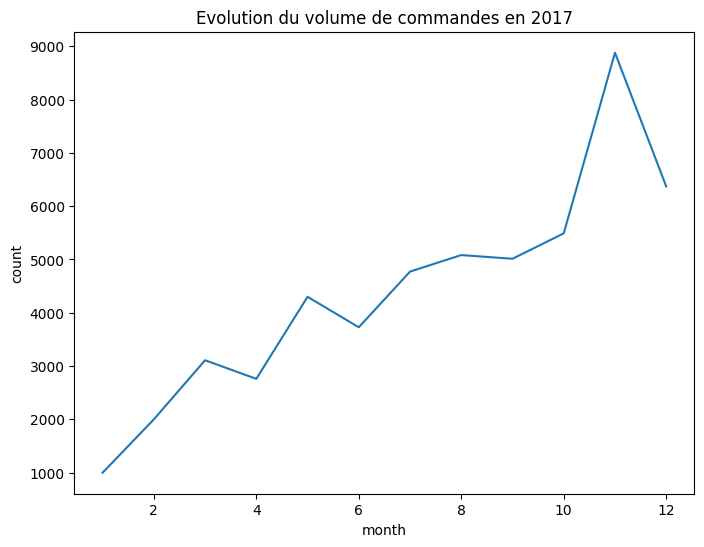

In [32]:
order_volume_year_2017 = df.loc[(df['year'] == 2017)].groupby(['month'])['order_id'].count()

plt.figure(figsize = (8,6))
fig2017 = sns.lineplot(x = order_volume_year_2017.index, y = order_volume_year_2017.values)
fig2017.set_title('Evolution du volume de commandes en 2017')
fig2017.set_ylabel('count');

Nous observons une tendance croissante avec quelques pics de saisonnalité.

**Evolution du nombre de commandes en 2018**

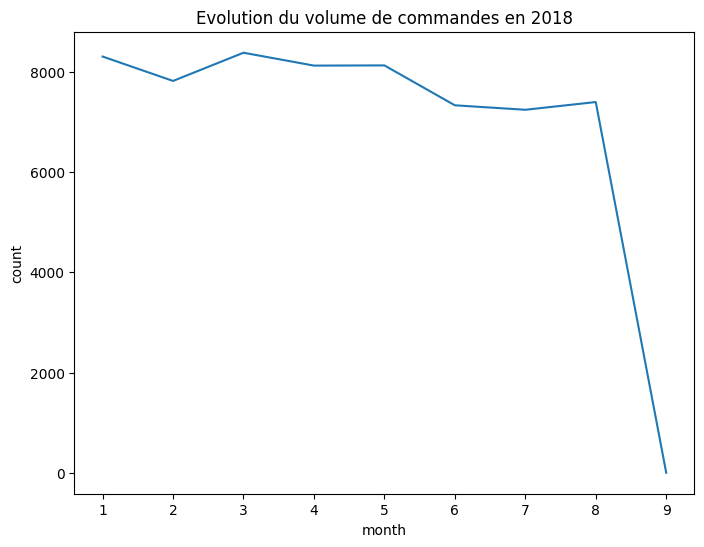

In [33]:
order_volume_year_2018 = df.loc[(df['year'] == 2018)].groupby(['month'])['order_id'].count()

plt.figure(figsize = (8,6))
fig2018 = sns.lineplot(x = order_volume_year_2018.index, y = order_volume_year_2018.values)
fig2018.set_title('Evolution du volume de commandes en 2018')
fig2018.set_ylabel('count');

Le nombre de commandes est plus élevé qu’en 2017, ce qui confirme la tendance croissante. On observe toutefois une grosse chute du nombre de commandes en septembre, cela pourrait être dû à un manque de données sur l’année 2018.

**Evolution du nombre de commandes totales selon les années**

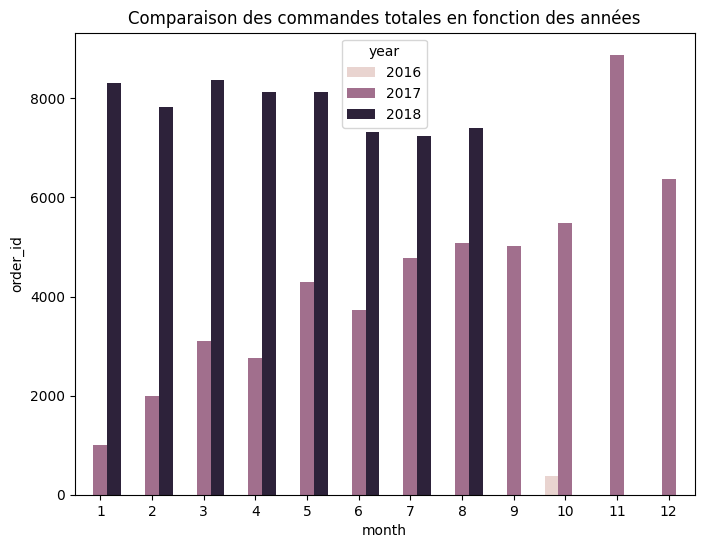

In [34]:
plt.figure(figsize = (8,6))
orders_year_comparison = sns.barplot(x = 'month', y = 'order_id', hue = 'year', data = df.groupby(['month','year'])['order_id'].count().reset_index())
orders_year_comparison.set_title('Comparaison des commandes totales en fonction des années');

Il n'y a quasiment pas de données en 2016 et passé septembre 2018, ce que l’on peut attribuer à un manque de données (vérifiable à l’aide d’un value_counts). Ce que l’on peut en revanche affirmer c’est que la tendance est croissante en 2017 et se stabilise en 2018. Notre site marchand est en plein essor, à l’image de son secteur. Pour la suite de notre étude nous pouvons supprimer les données de 2016.

In [35]:
df = df.loc[(df['year'] == 2017) | (df['year'] == 2018)]

**Evolution du nombre des commandes sur une semaine et sur une journée**

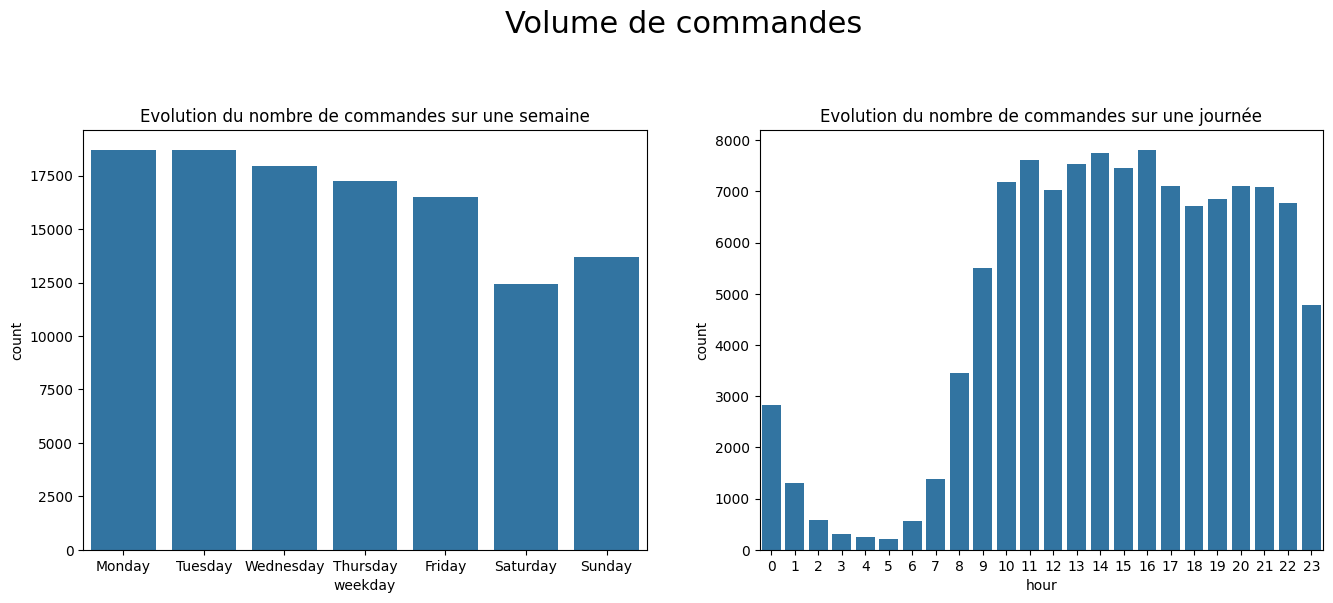

In [36]:
plt.figure(figsize = (16,12))
plt.suptitle('Volume de commandes', fontsize=22)

plt.subplot(221)
order_volume_week = sns.barplot(x = 'weekday', y = 'order_id', data = df.groupby(['weekday'])['order_id'].count().reset_index(),order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
order_volume_week.set_title('Evolution du nombre de commandes sur une semaine')
order_volume_week.set_ylabel('count')

plt.subplot(222)
order_volume_hour = sns.barplot(x = 'hour', y = 'order_id', data = df.groupby(['hour'])['order_id'].count().reset_index())
order_volume_hour.set_title('Evolution du nombre de commandes sur une journée')
order_volume_hour.set_ylabel('count');

Les brésiliens effectuent des achats les après-midi principalement, le jour le plus prolifique étant le lundi. Nous pouvons prendre en compte ces tendances pour mettre en place des promotions et optimiser encore plus les ventes.

**Evolution du Chiffre d'affaire cumulé en 2017**

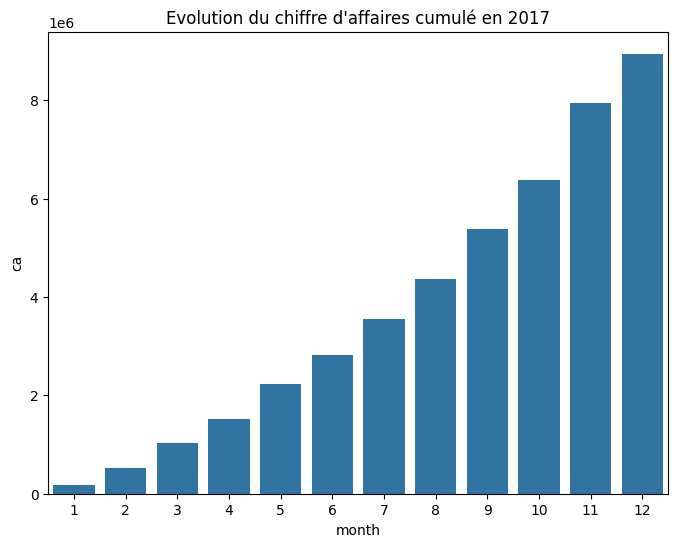

In [38]:
data = df.loc[(df['year'] == 2017)].groupby('month')['payment_value'].sum().reset_index()
data.loc[:, 'ca'] = data.loc[0, 'payment_value']
for i in range(1, len(data)):
    data.loc[i, 'ca'] = data.loc[i - 1, 'ca'] + data.loc[i, 'payment_value']

plt.figure(figsize = (8,6))
sns.barplot(x = 'month', y = 'ca', data = data).set_title("Evolution du chiffre d'affaires cumulé en 2017");

Le site de e-commerce a réalisé un chiffre d'affaires de 9 millions de dollars de sur l'année 2017 !

Nous souhaitons également attirer des vendeurs sur notre site, pour cela il faut leur montrer qu'ils peuvent réaliser des revenus attractifs.

**Revenus du meilleur vendeur**

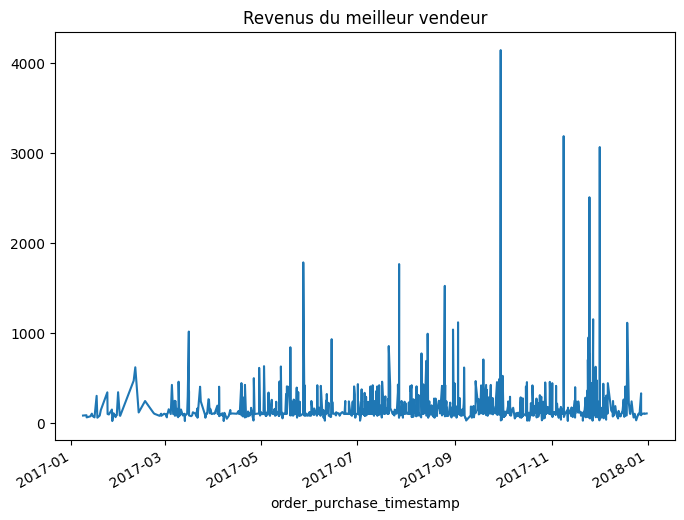

In [40]:
plt.figure(figsize = (8,6))
df.loc[(df['seller_id'] == df['seller_id'].value_counts().index[0]) & (df['year'] == 2017)].groupby('order_purchase_timestamp')['payment_value'].sum().plot().set_title('Revenus du meilleur vendeur');

Un vendeur peut réaliser jusqu'à 4000 dollars de revenus dans la même journée!

Nous allons à présent nous intéresser à la note des clients, variable qui sera la cible de notre modélisation.

**Distribution des notes**

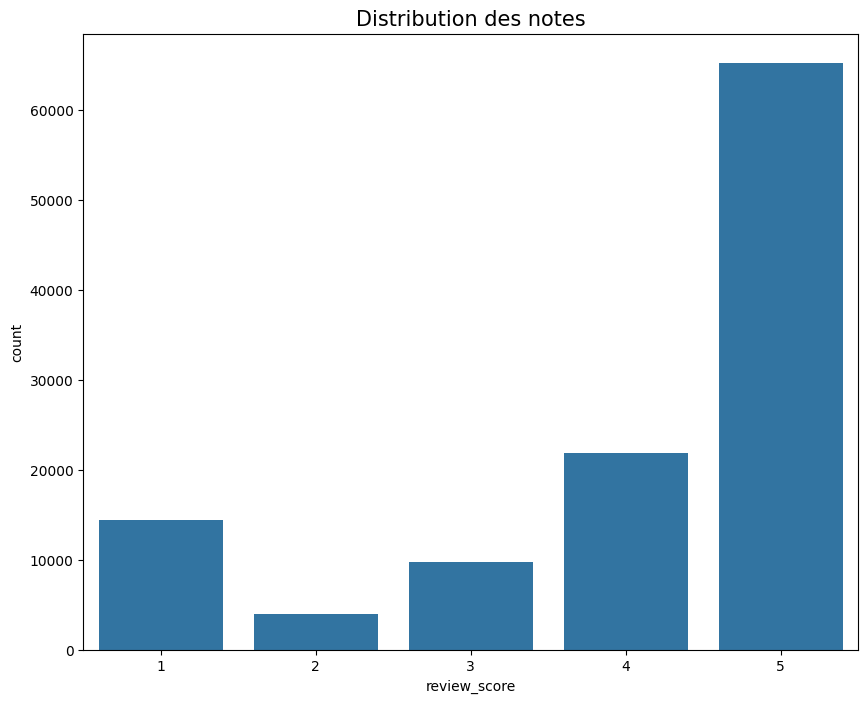

In [41]:
plt.figure(figsize = (10,8))
score_distribution = sns.countplot(x = df['review_score'])
score_distribution.set_title("Distribution des notes", fontsize = 15);

Nous pouvons constater un déséquilibre des classes qui risque d'impacter la modélisation.



**Distribution des notes selon la durée moyenne de livraison et selon le prix moyen**

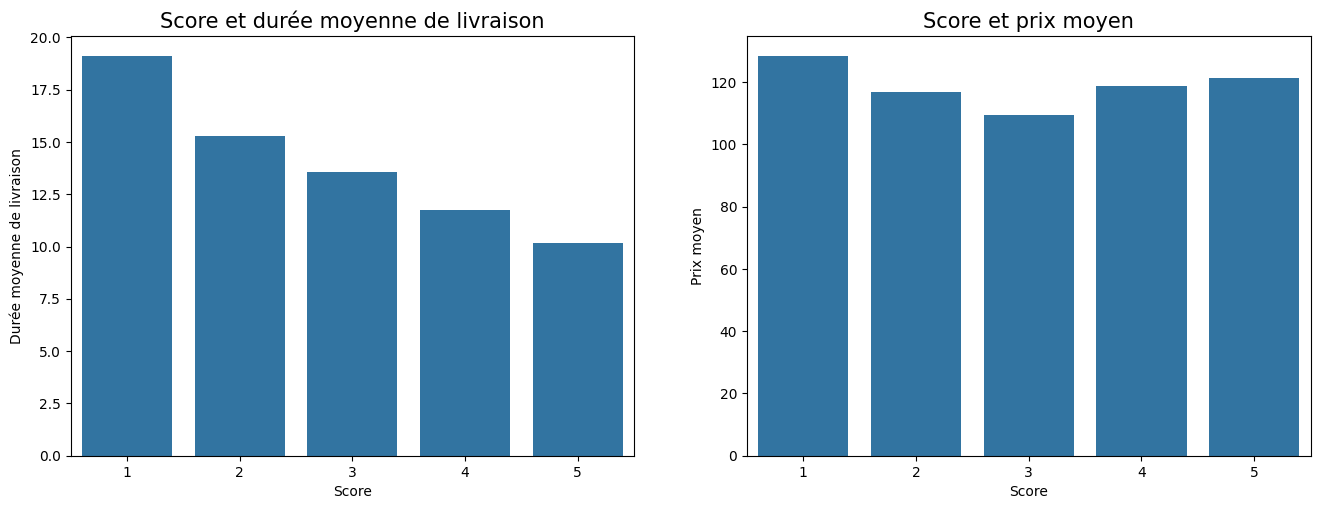

In [42]:
plt.figure(figsize=(16,12))

plt.subplot(221)
delivery_ratings = sns.barplot(x = [i for i in range(1,6)], y = df.groupby(['review_score'])['delivery_duration'].mean().values)
delivery_ratings.set_title("Score et durée moyenne de livraison", fontsize = 15)
delivery_ratings.set_xlabel("Score", fontsize = 10)
delivery_ratings.set_ylabel("Durée moyenne de livraison", fontsize = 10)

plt.subplot(222)
price_ratings = sns.barplot(x = [i for i in range(1,6)], y = df.groupby(['review_score'])['price'].mean().values)
price_ratings.set_title("Score et prix moyen", fontsize = 15)
price_ratings.set_xlabel("Score", fontsize = 10)
price_ratings.set_ylabel("Prix moyen", fontsize = 10);

Nous en déduisons que la durée de livraison aura un impact important dans notre modélisation ultérieure. Plus la durée de livraison est longue, plus le client est susceptible de noter sévèrement.

Le prix a un impact moins important sur le score. Nous remarquons que de nombreux articles bien notés ont un prix au-dessus de la moyenne : le prix a moins d'importance si les produits commandés sont de qualité.

**Relation entre les frais de livraison et le score**

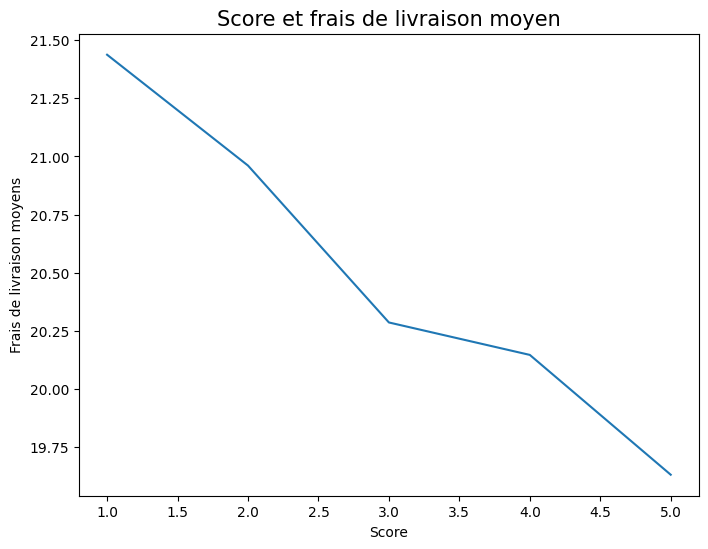

In [44]:
plt.figure(figsize = (8,6))
freight_ratings = sns.lineplot(x = [i for i in range(1,6)], y = df.groupby(['review_score'])['freight_value'].mean().values)
freight_ratings.set_title("Score et frais de livraison moyen", fontsize = 15)
freight_ratings.set_xlabel("Score", fontsize = 10)
freight_ratings.set_ylabel("Frais de livraison moyens", fontsize = 10);

Les frais de livraisons ont un impact sur le score, plus ils sont élevés, plus le client a tendance à noter sévèrement l'article.

**Scores pour les catégories 'health_beauty' et 'diapers_and_hygiene'**

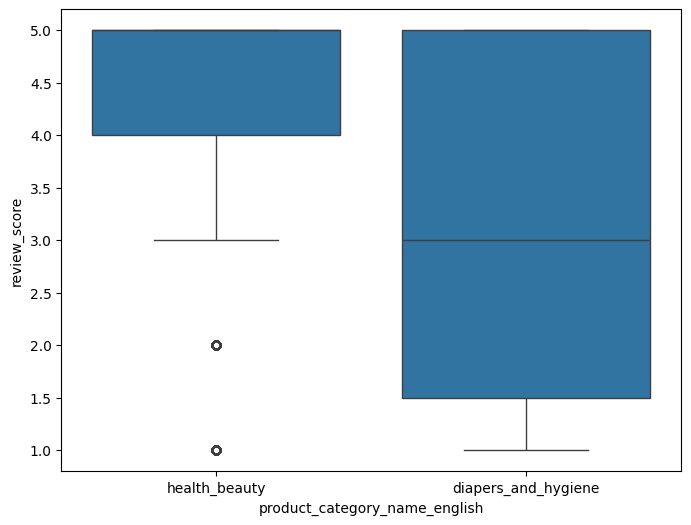

In [45]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'product_category_name_english', y = 'review_score', data = df.loc[df['product_category_name_english'].isin(['health_beauty', 'diapers_and_hygiene'])]);

Nous remarquons que les articles peuvent être notés très différemment selon leur catégorie.



**Quantité de photos moyenne en fonction de la note laissée par le client.**

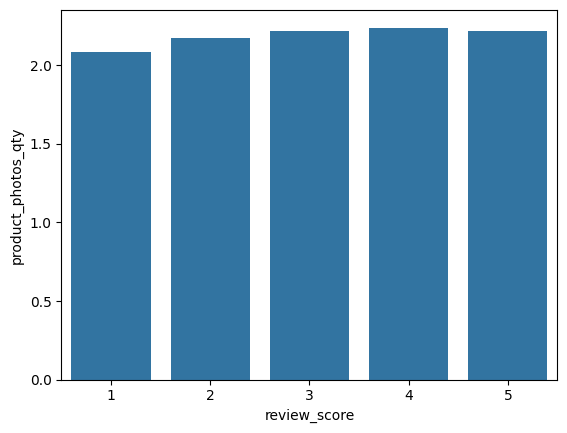

In [46]:
sns.barplot(x = 'review_score', y = 'product_photos_qty', data = df.groupby('review_score')['product_photos_qty'].mean().reset_index());

La quantité de photos disponible n'a pas d'incidence sur la note laissée par le client, nous ne la prendrons pas en compte pour notre modèle.

###III) Feature Engineering

Nous pouvons raisonnablement penser que les avis laissés par les clients précédents auront une influence non négligeable sur le modèle de prédiction. Or, nous ne disposons pas de cette variable dans notre jeu de données actuellement. Faire une moyenne de tous les autres avis en utilisant mean pour un article donné serait incohérent car cela prendrait en compte les avis futurs également.

Nous allons créer une colonne 'number_review_before' correspondant au nombre d’avis laissés avant l’achat d’un article

In [47]:
df['number_review_before'] = df.sort_values(['product_id', 'review_creation_date']).groupby(['product_id']).cumcount().reset_index(drop = True)

df['number_review_before'].value_counts() # Affichage du nombre maximal d'avis laissés avant un achat

,count
number_review_before,
0.0,31914
1.0,15125
2.0,9282
3.0,6626
4.0,5065
...,...
520.0,1
519.0,1
518.0,1


A l’aide de la colonne précédente, nous allons créer une colonne correspondant à la note moyenne de l’article avant son achat.

In [48]:
df['review_score_before'] = df.sort_values(['product_id', 'review_creation_date']).groupby(['product_id'])['review_score'].cumsum().reset_index(drop = True).shift() / df['number_review_before']

df['review_score_before'] = df['review_score_before'].replace([np.inf, -np.inf], 0)

### IV - Préparation des données


**1. Sélection des variables**

Pour notre modèle nous utiliserons la variable cible 'review_score' ainsi que les variables explicatives suivantes, sur la base des visualisations précédentes et de notre feature engineering:

order_status

product_category_name_english

price

delivery_duration

difference_between_expected_and_real_delivery_date

freight_value

review_score_before

number_review_before

hour

weekday

**2. Preprocessing**

Il y a plusieurs étapes dans ce preprocessing. Il faut :

-Sélectionner seulement les colonnes évoquées plus haut

-Séparer nos données en train/test

-Remplacer les valeurs manquantes

-Encoder les variables catégorielles

**Séparation de notre jeu de données**

In [49]:
X = df.drop(['review_score'], axis = 1)
y = df['review_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
cat_cols = ['order_status','product_category_name_english']
num_cols = ['price','delivery_duration', 'difference_between_expected_and_real_delivery_date', 'freight_value', 'review_score_before', 'number_review_before']
circular_cols = ['hour', 'weekday']

cat_train = X_train[cat_cols]
cat_test = X_test[cat_cols]
num_train = X_train[num_cols]
num_test = X_test[num_cols]
circular_train = X_train[circular_cols]
circular_test = X_test[circular_cols]

Les variables temporelles cycliques présentent un défi unique en matière de traitement et d'encodage. Contrairement aux variables temporelles linéaires telles que les dates ou les horodatages, les variables temporelles cycliques, telles que les mois de l'année ou les heures de la journée, sont périodiques et présentent une structure cyclique qui peut ne pas être capturée efficacement par les méthodes d'encodage traditionnelles.

L'Encodage trigonométrique est une méthode utilisée pour encoder des variables cycliques, telles que les mois de l'année ou les heures de la journée, en variables numériques. Elle utilise les fonctions trigonométriques, telles que sinus et cosinus, pour capturer la périodicité des données. Chaque période cyclique est représentée par une paire de fonctions trigonométriques, généralement sinus et cosinus, qui permettent de conserver l'information sur la phase et l'amplitude de la variation cyclique.
Cette méthode est utile car elle préserve la relation de périodicité entre les valeurs encodées, tout en évitant les problèmes liés à l'ordinalité ou à l'utilisation de valeurs arbitraires.

Ainsi, si l'on dispose d'une variable 'hour', nous pouvons l'encoder ainsi : hour_cos = cos(2np.pih/24) et hour_sin = sin(2np.pih/24)

Concrètement, nous remplaçons la variable par ses coordonnées sur le cercle trigonométrique.

Text(0.5, 1.0, 'Cercle trigonométrique')

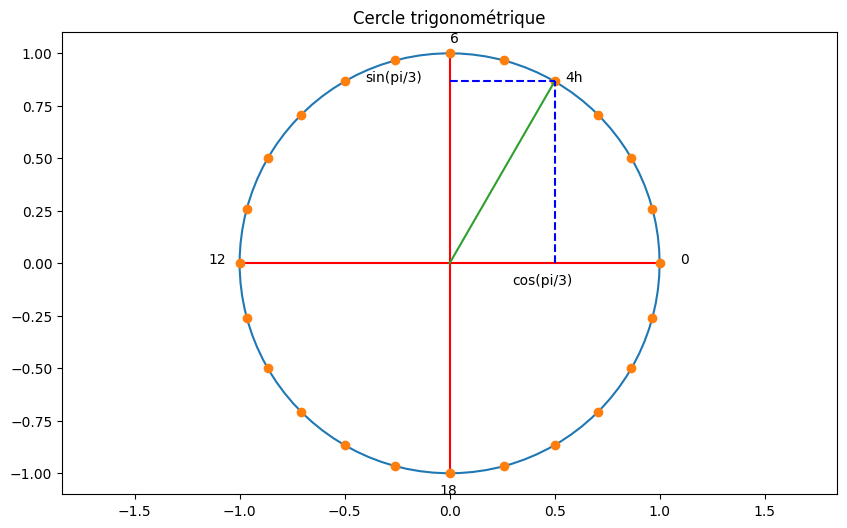

In [50]:
theta = np.linspace(0,2*np.pi,100)
X = np.cos(theta)
Y = np.sin(theta)

# Tracé du cercle trigonométrique
plt.figure(figsize=(10,6))
plt.plot(X,Y)

# Diamètres du cercle
plt.plot(np.linspace(-1,1,100),np.array([0]*100),'r')
plt.plot(np.array([0]*100),np.linspace(-1,1,100),'r')

# Tracé des 24 points sur le cercle
plt.plot([np.cos(2 * np.pi * h / 24) for h in range(24)], [np.sin(2 * np.pi * h / 24) for h in range(24)], 'o')

# Exemple d'encodage pour 4h
plt.plot([0,np.cos(np.pi/3)],[0,np.sin(np.pi/3)])
plt.plot(np.array([np.cos(np.pi/3)]*100),np.linspace(0,np.sin(np.pi/3),100),'b--')
plt.plot(np.linspace(0,np.cos(np.pi/3),100),np.array([np.sin(np.pi/3)]*100),'b--')
plt.annotate('cos(pi/3)', xy=(np.cos(np.pi/3), 0), xytext=(np.cos(np.pi/3)-0.2, -0.1))
plt.annotate('sin(pi/3)', xy=(0, np.sin(np.pi/3)), xytext=(-0.4, np.sin(np.pi/3)))

# Annotations
plt.annotate('4h', xy=(np.cos(np.pi/3), np.sin(np.pi/3)), xytext=(np.cos(np.pi/3)+0.05, np.sin(np.pi/3)))
plt.annotate('0', xy=(1,0), xytext=(1.1,0))
plt.annotate('6', xy=(0,1), xytext=(0,1.05))
plt.annotate('12', xy=(-1,0), xytext=(-1.15,0))
plt.annotate('18', xy=(0,-1), xytext=(-0.05,-1.1))

plt.axis("equal")
plt.title("Cercle trigonométrique")

**Encodage de la variable cyclique 'hour' à l'aide de fonctions trigonométriques.**

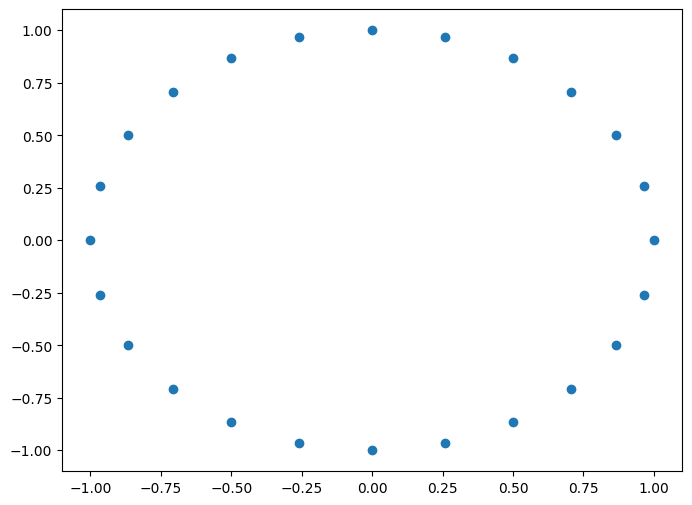

In [52]:
circular_train.loc[:, 'sin_hour'] = circular_train.loc[:, 'hour'].apply(lambda h : np.sin(2 * np.pi * h / 24))
circular_train.loc[:, 'cos_hour'] = circular_train.loc[:, 'hour'].apply(lambda h : np.cos(2 * np.pi * h / 24))

circular_test.loc[:, 'sin_hour'] = circular_test.loc[:, 'hour'].apply(lambda h : np.sin(2 * np.pi * h / 24))
circular_test.loc[:, 'cos_hour'] = circular_test.loc[:, 'hour'].apply(lambda h : np.cos(2 * np.pi * h / 24))

plt.figure(figsize = (8,6))
plt.plot([np.cos(2 * np.pi * h / 24) for h in range(24)], [np.sin(2 * np.pi * h / 24) for h in range(24)], 'o')
plt.show()

 Remplacement des valeurs dans la colonne 'weekday' par des entiers allant de 1 à 7, puis encodage de la colonne en utilisant des fonctions trigonométriques.

<ipython-input-54-3a8b2ba3619f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  circular_train.loc[:, 'sin_weekday'] = circular_train.loc[:, 'weekday'].replace({'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4, 'Friday' : 5, 'Saturday' : 6, 'Sunday' : 7}).apply(lambda h : np.sin(2 * np.pi * h / 7))
<ipython-input-54-3a8b2ba3619f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  circular_train.loc[:, 'cos_weekday'] = circular_train.loc[:, 'weekday'].replace({'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4,

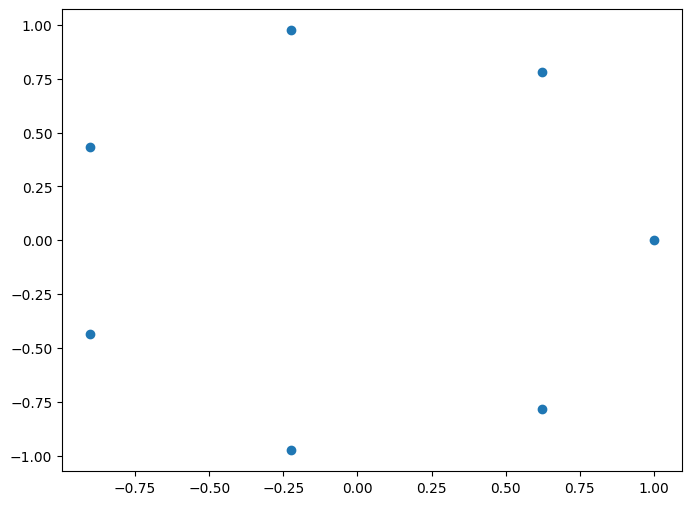

In [54]:
circular_train.loc[:, 'sin_weekday'] = circular_train.loc[:, 'weekday'].replace({'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4, 'Friday' : 5, 'Saturday' : 6, 'Sunday' : 7}).apply(lambda h : np.sin(2 * np.pi * h / 7))
circular_train.loc[:, 'cos_weekday'] = circular_train.loc[:, 'weekday'].replace({'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4, 'Friday' : 5, 'Saturday' : 6, 'Sunday' : 7}).apply(lambda h : np.cos(2 * np.pi * h / 7))

circular_test.loc[:, 'sin_weekday'] = circular_test.loc[:, 'weekday'].replace({'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4, 'Friday' : 5, 'Saturday' : 6, 'Sunday' : 7}).apply(lambda h : np.sin(2 * np.pi * h / 7))
circular_test.loc[:, 'cos_weekday'] = circular_test.loc[:, 'weekday'].replace({'Monday' : 1, 'Tuesday' : 2, 'Wednesday' : 3, 'Thursday' : 4, 'Friday' : 5, 'Saturday' : 6, 'Sunday' : 7}).apply(lambda h : np.cos(2 * np.pi * h / 7))

plt.figure(figsize = (8,6))
plt.plot([np.cos(2 * np.pi * h / 7) for h in range(7)], [np.sin(2 * np.pi * h / 7) for h in range(7)], 'o')
plt.show()

**Remplacement des valeurs manquantes**

In [55]:
numeric_imputer = SimpleImputer(strategy = 'median')
categorical_imputer = SimpleImputer(strategy = 'most_frequent')

num_train_imputed = numeric_imputer.fit_transform(num_train)
num_test_imputed = numeric_imputer.transform(num_test)

cat_train_imputed = categorical_imputer.fit_transform(cat_train)
cat_test_imputed = categorical_imputer.transform(cat_test)

num_train_imputed = pd.DataFrame(num_train_imputed, columns = num_cols)
cat_train_imputed = pd.DataFrame(cat_train_imputed, columns = cat_cols)
num_test_imputed = pd.DataFrame(num_test_imputed, columns = num_cols)
cat_test_imputed = pd.DataFrame(cat_test_imputed, columns = cat_cols)

circular_train = circular_train.drop(['hour','weekday'],axis = 1)
circular_test = circular_test.drop(['hour','weekday'],axis = 1)

X_train_imputed = pd.concat([num_train_imputed, cat_train_imputed, circular_train], axis = 1)
X_test_imputed = pd.concat([num_test_imputed, cat_test_imputed, circular_test], axis = 1)

**Encodage des variables catégorielles**

In [57]:
encoder = OneHotEncoder(sparse_output=False, drop = 'first')

cat_train_encoded = encoder.fit_transform(cat_train_imputed)

cat_test_encoded = encoder.transform(cat_test_imputed)

cat_train_encoded = pd.DataFrame(cat_train_encoded, columns = encoder.get_feature_names_out(cat_cols))
cat_test_encoded = pd.DataFrame(cat_test_encoded, columns = encoder.get_feature_names_out(cat_cols))

X_train_encoded = pd.concat([num_train_imputed, cat_train_encoded], axis = 1)
X_test_encoded = pd.concat([num_test_imputed, cat_test_encoded], axis = 1)

### V - Modélisation

In [58]:
model1 = RandomForestClassifier(random_state = 42)
model2 = LogisticRegression(random_state = 42)

model1.fit(X_train_encoded, y_train)
model2.fit(X_train_encoded, y_train)

rf_prediction = model1.predict(X_test_encoded)
reg_prediction = model2.predict(X_test_encoded)

display(accuracy_score(y_test.values, reg_prediction))
display(accuracy_score(y_test.values, rf_prediction))
display(pd.crosstab(rf_prediction, y_test.values, colnames = ['Classes réelles'], rownames = ['Classes prédites']))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5857415603575458

0.6544302698949926

Classes réelles,1,2,3,4,5
Classes prédites,,,,,
1,1525,144,137,120,227
2,8,146,5,5,21
3,16,5,296,35,75
4,71,26,78,739,399
5,1189,498,1405,3500,12376


Nous constatons que le modèle Random Forest présente une meilleure accuracy. Au niveau de la matrice de confusion de ce modèle, nous remarquons que les classes 2 et 3 sont souvent confondues avec la classe 1. La classe 4 est souvent confondue avec la classe 5. Nous allons donc fusionner les classes 1, 2 et 3 ainsi que les classes 4 et 5 pour se ramener à un problème de classification binaire.

In [59]:
y_train = pd.cut(x = y_train, bins = [0, 3, 5], labels = [0,1])
y_test = pd.cut(x = y_test, bins = [0, 3, 5], labels = [0,1])

model = RandomForestClassifier(random_state = 42)
model.fit(X_train_encoded, y_train)
rf_prediction = model.predict(X_test_encoded)

display(accuracy_score(y_test.values, rf_prediction))

display(pd.crosstab(rf_prediction, y_test.values, colnames = ['Classes réelles'], rownames = ['Classes prédites']))

0.8373687407793109

Classes réelles,0,1
Classes prédites,,
0,2292,491
1,3257,17006


Nous avons une meilleure accuracy, cependant le nombre de faux positifs est très élevé. Cela peut s'expliquer par le fait que toutes nos classes initiales sont souvent confondues avec la classe 5. Cette confusion peut s'expliquer par le déséquilibre des classes, la classe n°5 étant largement majoritaire.

**Feature importance du modèle**

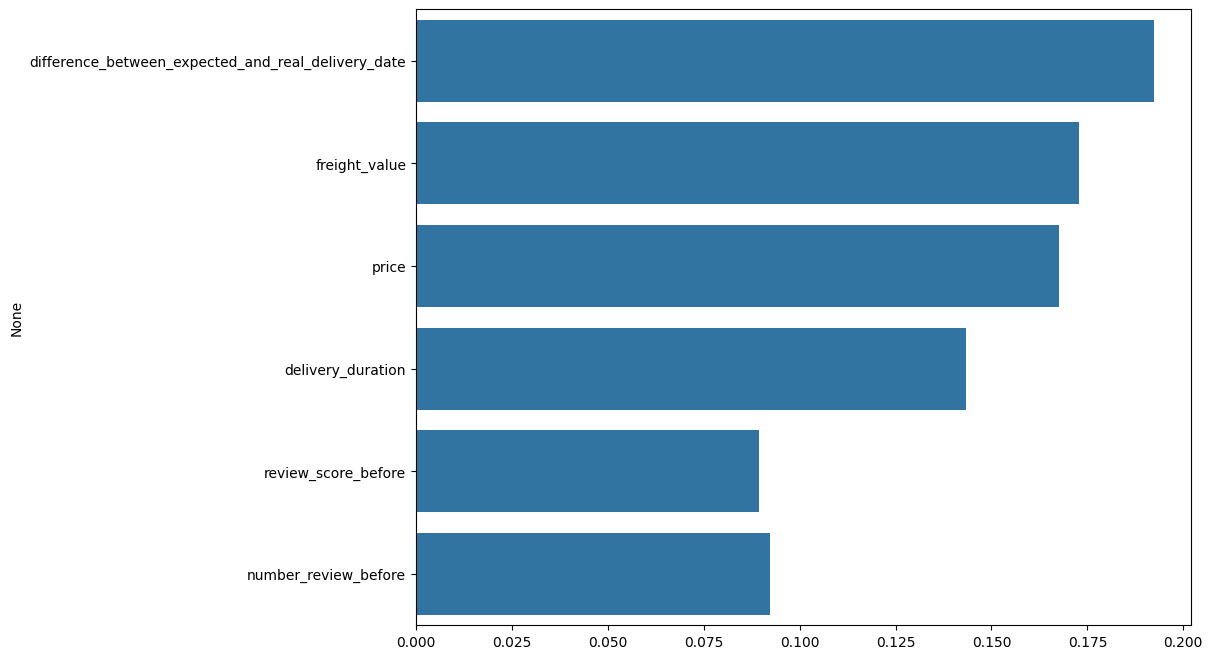

In [60]:
plt.figure(figsize = (10,8))
sns.barplot(x = model.feature_importances_[:6], y = X_test_encoded.columns[:6], order = ['difference_between_expected_and_real_delivery_date', 'freight_value', 'price', 'delivery_duration', 'review_score_before', 'number_review_before']);